# Summary of endpoint plot for different physics variations

The goal of this plot is to show the change in the 'endpoint fractions' for low vs high Z for all the physics variations explored
I.e., 

$$
\Delta f_{endpoint, i} = f_{endpoint, i}(high Z) - f_{endpoint, i}(low Z)
$$

where i represents the different possible outcomes: Stellar mergers, BBH systems, Merging BBH, BHNS systems, Merging BHNS, NSNS systems, Merging NSNS, WD systems, Massless Remnant, Other



In [3]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec

# add run_data path to sys
import sys
sys.path.append('./run_data')
from definitions import sim_flags_dict

home_dir = os.path.expanduser("~") 
compas_v = "v03.01.02" # "v02.46.01/"#v02.35.02/"
datar_root =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"

sim_name =  'NewWinds_RemFryer2012_noMSwinds'#  'NewWinds_RemFryer2012_noNSBHkick'#'OldWinds_RemFryer2012'#  


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



## Start with collecting the data

First define the necessary functions to load the data, and count the relevant numbers/objects

In [42]:
#####################################
# Take the base potential DCO progenitor table
def load_potentialDCO(sim_name, prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'):
    """_summary_

    Args:
        sim_name (str): simulation to load
        prog_table_name (str): name of pot DCO table to load (default ='potential_DCO_progenitors_Allinfo.h5')

    Returns:
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors (pandas tables)
    """
    if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
        potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
        print('Table exists, reading in... ')

        potential_DCO_progenitors.reset_index(drop=True, inplace=True)

        with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
            DCO = All_data['BSE_Double_Compact_Objects']
            st1 = DCO['Stellar_Type(1)'][()]
            st2 = DCO['Stellar_Type(2)'][()]
            dco_merger = DCO['Merges_Hubble_Time'][()]  
            DCO_seed = DCO['SEED'][()]
            # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
            BBH_bool = np.logical_and(st1 == 14,st2 == 14)
            BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                                    np.logical_and(st1 == 14,st2 == 13) )
            NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
            merger_bool = dco_merger == 1

            # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
            potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
            potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
            potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]

        return potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors

    else:
        print(f'error, {datar_root}/{sim_name}/{prog_table_name} does not exist, you should make it using "DataManipulation.ipynb" first')
        return None, None, None, None

        

#####################################
def get_endpoint_numbers(table):
    """_summary_

    Args:
        table (pandas table): potential_DCO_progenitors

    Returns:
        numpers of systems/events per metallicity
        N_tot_DCO_prog,                             total potential DCO progenitors per Z
        N_unbound, N_mergers,                       The number that is unbound, and the number of stellar mergers
        N_BBH, , N_BHNS, N_NSNS,                    counts of BBH, BHNS, NSNS 
        N_mergingBBH, N_mergingBHNS, N_mergingNSNS  counts BBH, BHNS, NSNS that merge within a Hubble time
        N_WD,                                       systems containing a white dwarf
        N_massless_rem,                             systems containing a massless remnant
        other_bool                                  anything else?
    """

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (~DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD
    # Check if there are thing that are both listed as BBH and unbound
    BBH_and_unbound = (np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14) * (table['Unbound'] == 1)  )
    print('BBH and unbound', BBH_and_unbound.sum())

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool


### Now create a class to store all the information we need

this should make the plotting a lot easier and faster

In [43]:
# class to store simulation data
class Simulation:
    def __init__(self, sim_name, label, results_table):
        self.sim_name = sim_name
        self.label = label
        self.results_table = self.collect_results(sim_name)

    def collect_results(self, sim_name = 'NewWinds_RemFryer2012'):
        # Load the potential DCO progenitors
        potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors = load_potentialDCO(sim_name)

        # List of tables of pot DCO progenitors
        titles  = ["BBH", "BHNS", "NSNS"]
        dfs     = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

        # Initialize an empty dictionary to store the results
        results = {}

        # Loop over the dataframes and titles
        for df, title in zip(dfs, titles):
            print(f' {title} ')
            # Get the results from get_endpoint_numbers
            results[title] = get_endpoint_numbers(table = df)

        return results


# Dictionary to map simulation names to labels and colors we want to use in the plots
sim_name_label_dict = {
    'NewWinds_RemFryer2012': 'Fiducial', 
    'OldWinds_RemFryer2012': 'Old Winds',
    'NewWinds_RemMullerMandel': 'M&M remnant',
    'NewWinds_RemFryer2012_noBHkick': 'No BH kick',
    'NewWinds_RemFryer2012_noNSBHkick': 'No natal kicks',
    'NewWinds_RemFryer2012_noWRwinds': 'No WR winds',
    'NewWinds_RemFryer2012_noMSwinds': 'No MS winds',
    'RemFryer2012_NOwinds': 'No winds'
    }


########################################
# Loading and counting systems and then creating simulation objects
# This takes a lot of time, so we'll use multiprocessing to speed things up
# still takes about 2-3 min to run
import multiprocessing as mp

# Define a function to create a simulation object
def create_simulation(sim_name):
    print(f'Working on {sim_name}...')

    sim_obj = Simulation(sim_name, sim_name_label_dict[sim_name], None)
    return sim_obj


# Create a pool of workers
with mp.Pool(mp.cpu_count()) as pool:
    simulations = pool.map(create_simulation, sim_name_label_dict.keys())


Working on NewWinds_RemFryer2012...Working on NewWinds_RemFryer2012_noBHkick...Working on OldWinds_RemFryer2012...Working on NewWinds_RemMullerMandel...Working on NewWinds_RemFryer2012_noNSBHkick...Working on NewWinds_RemFryer2012_noWRwinds...

Working on NewWinds_RemFryer2012_noMSwinds...

Working on RemFryer2012_NOwinds...



Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
Table exists, reading in... 
 BBH 
 BBH 
 BBH 
 BBH 
 BBH 
BBH and unbound 33959
 BHNS 
BBH and unbound 42748
 BHNS 
BBH and unbound 40712
 BHNS 
BBH and unbound 4088
 NSNS 
BBH and unbound 7785
 NSNS 
BBH and unbound 9126
 NSNS 
BBH and unbound 33217
 BHNS 
BBH and unbound 401
BBH and unbound 8553
 NSNS 
BBH and unbound 2741
BBH and unbound 3324
BBH and unbound 2601
BBH and unbound 56257
 BHNS 
BBH and unbound 8177
 NSNS 
Table exists, reading in... 
BBH and unbound 2290
Table exists, reading in... 
 BBH 
 BBH 
Table exists, reading in... 
 BBH 
B

# Plot the results! 

BBH
 NewWinds_RemFryer2012  Fiducial
 OldWinds_RemFryer2012  Old Winds
 NewWinds_RemMullerMandel  M&M remnant
 NewWinds_RemFryer2012_noBHkick  No BH kick
 NewWinds_RemFryer2012_noNSBHkick  No natal kicks
 NewWinds_RemFryer2012_noWRwinds  No WR winds
 NewWinds_RemFryer2012_noMSwinds  No MS winds
 RemFryer2012_NOwinds  No winds
BHNS
 NewWinds_RemFryer2012  Fiducial
 OldWinds_RemFryer2012  Old Winds
 NewWinds_RemMullerMandel  M&M remnant
 NewWinds_RemFryer2012_noBHkick  No BH kick
 NewWinds_RemFryer2012_noNSBHkick  No natal kicks
 NewWinds_RemFryer2012_noWRwinds  No WR winds
 NewWinds_RemFryer2012_noMSwinds  No MS winds
 RemFryer2012_NOwinds  No winds


/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors ('#b0c4dd') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors ('#000000') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors ('#b0c4dd') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors 

NSNS
 NewWinds_RemFryer2012  Fiducial
 OldWinds_RemFryer2012  Old Winds
 NewWinds_RemMullerMandel  M&M remnant
 NewWinds_RemFryer2012_noBHkick  No BH kick
 NewWinds_RemFryer2012_noNSBHkick  No natal kicks
 NewWinds_RemFryer2012_noWRwinds  No WR winds
 NewWinds_RemFryer2012_noMSwinds  No MS winds
 RemFryer2012_NOwinds  No winds


/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors ('#b0c4dd') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
/tmp/ipykernel_3173437/1573048195.py:50: UserWarning: You passed a edgecolor/edgecolors ('#000000') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\


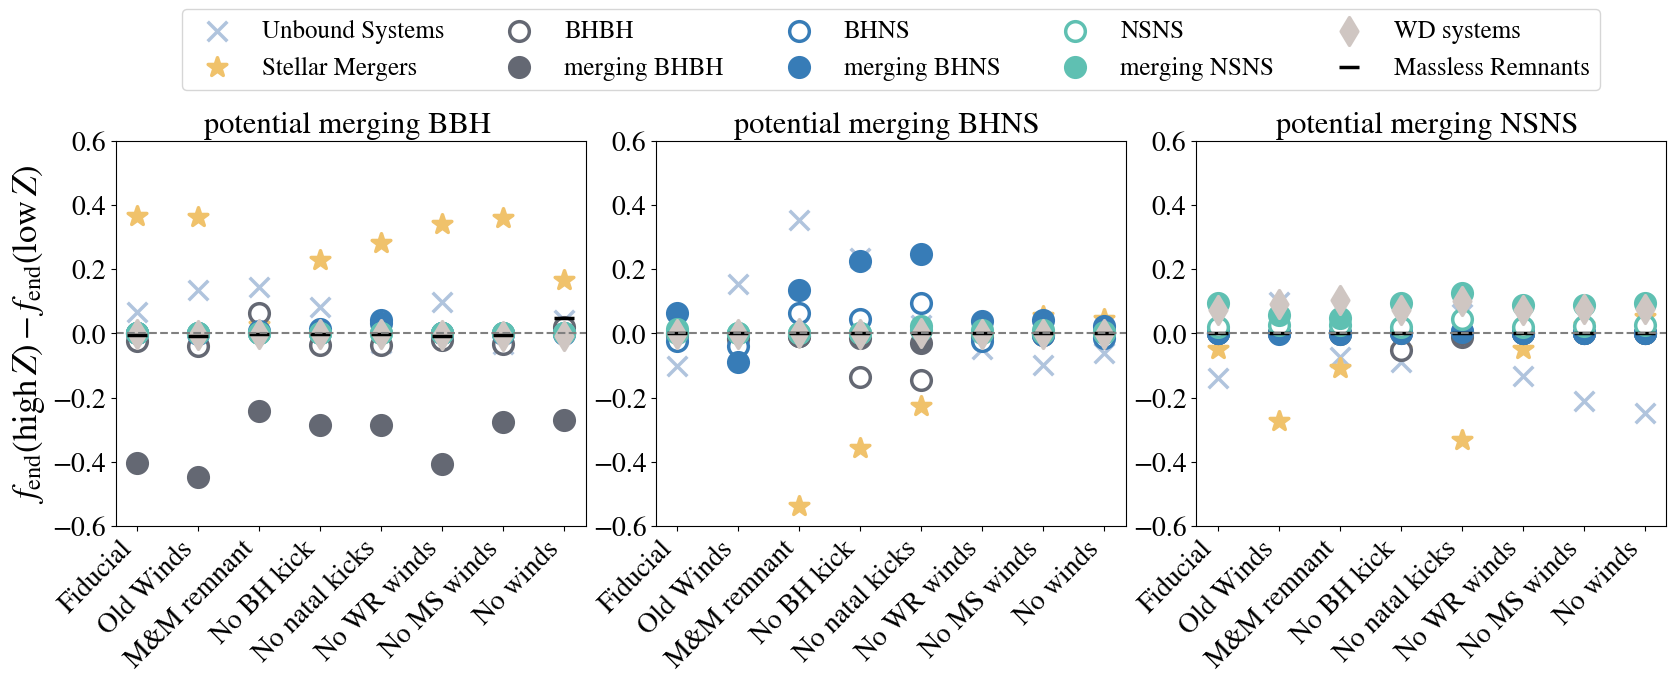

In [51]:
###########################################
# Create a figure
fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)] # Create 3 subplots on a line

simulation_labels = [simulation.label for simulation in simulations]  # Get all simulation labels

######################################
# Loop over the different DCO flavors
titles  = ["BBH", "BHNS", "NSNS"]
for i, ax in enumerate(axes):

    print(f'{titles[i]}')

    ######################################
    # Loop over the simulations
    for s, simulation in enumerate(simulations):
        print(f' {simulation.sim_name}  {simulation.label}')

        # results from the simulation
        N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = simulation.results_table[titles[i]] # get_endpoint_numbers(table = df)

        # Define a dictionary to map the labels to their respective conditions, colors, and markers
        endpoint_dict = {
            'Unbound Systems': {'data': N_unbound, 'edgecolor': '#b0c4dd', 'color': '#b0c4dd', 'marker': 'x'},
            'Stellar Mergers': {'data': N_mergers, 'edgecolor': '#F0C26B', 'color': '#F0C26B', 'marker': '*'},
            'BHBH': {'data': N_BBH, 'edgecolor': '#646873', 'color': 'white', 'marker': 'o'},
            'merging BHBH': {'data': N_mergingBBH, 'edgecolor': '#646873', 'color': '#646873', 'marker': 'o'},
            'BHNS': {'data': N_BHNS, 'edgecolor': '#377CB7', 'color': 'white', 'marker': 'o'},
            'merging BHNS': {'data': N_mergingBHNS, 'edgecolor': '#377CB7', 'color': '#377CB7', 'marker': 'o'},
            'NSNS': {'data': N_NSNS, 'edgecolor': '#5FC0B2', 'color': 'white', 'marker': 'o'},
            'merging NSNS': {'data': N_mergingNSNS, 'edgecolor': '#5FC0B2', 'color': '#5FC0B2', 'marker': 'o'},
            'WD systems': {'data': N_WD, 'edgecolor': '#cfc6c2', 'color': '#cfc6c2', 'marker': 'd'},
            'Massless Remnants': {'data': N_massless_rem, 'edgecolor': '#000000', 'color': '#000000', 'marker': '_'}
        }

        # We will now plot f(highest metallicity) - f(lowest metallicity) / N_tot_DCO_prog
        # the key is the metallicity, N_tot_DCO_prog is the same at all Z
        for label, attributes in endpoint_dict.items():
            # Only label the first time
            label = label if s == 0 else None

            # Plot f_high z - f_low z 
            avg_high_z = (attributes['data'][0.030000] + attributes['data'][0.020000])/2 # average N of 2 highest Z
            avg_low_z = (attributes['data'][0.000100] + attributes['data'][0.00017321])/2  # average N of 2 lowest Z

            ax.scatter(s, (avg_high_z - avg_low_z)/N_tot_DCO_prog[0.030000],\
                marker= attributes['marker'], color=attributes['color'], edgecolor = attributes['edgecolor'], lw = 2.5,  s=200, label=label)

            # ax.scatter(s, (attributes['data'][0.030000] - attributes['data'][0.000100])/N_tot_DCO_prog[0.030000],\
            #     marker= attributes['marker'], color=attributes['color'], edgecolor = attributes['edgecolor'], s=200, label=label)

    #############
    ## Plotvalues per ax
    ax.axhline(0, linestyle='--', color='gray')# Plot the null line

    # Set the title and ylim
    ax.set_title(f'potential merging {titles[i]} ', fontsize = 22)
    ax.set_ylim(-0.6, 0.6)

    # Set the x-tick labels to be the simulation labels
    ax.set_xticks(range(len(simulation_labels)))
    ax.set_xticklabels(simulation_labels, rotation=45, ha = 'right')  # Rotate labels for better visibility if needed
    
    # ax.set_yscale('symlog')

#############
axes[0].set_ylabel(r'$f_{\mathrm{end}}(\mathrm{high} \, Z) - f_{\mathrm{end}}(\mathrm{low} \, Z)$', fontsize = 25)
# axes[0].set_ylabel(r'$\frac{f(Z=0.03) - f(Z=0.0001)}{N_{\rm{tot, pot DCO}}}$', fontsize = 30)
axes[1].legend(bbox_to_anchor=(0.5, 1.1), loc='lower center', fontsize = 18, ncols = 5)

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.15)

plt.savefig(f'../plots/{compas_v}/Summary_end_of_evol.pdf', bbox_inches='tight')

plt.show()